In [293]:
### Generic Set Up

% matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import minmax_scale
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train = pd.read_csv('train.csv')
train = train.drop(labels='Id', axis=1)
holdout = pd.read_csv('test.csv')
Id = holdout['Id']
holdout = holdout.drop(labels='Id', axis=1)
# train.head()

### Other Common Queries

In [269]:
### DO NOT DELETE
### Working Dictionary of Submission Accuracies
# how to delete? (for 'Sample_A/B' and 'Test')
# ['Sample_A/B'] = [0.5, 0.7]
recorded_submissions

### There's an easy way to enter these into a DataFrame, to make things neater
### 4 columns (exluding Id) to hold:
# model w/ hyperparameters
# columns used
# training accuracy
# submission score

{'Sample_A/B': [0.5, 0.7], 'Test': 'Eliminate this Later'}

In [256]:
### Quick Start Linear Regression
### Drops object columns, treats categorical as numerical
### But it gives an immediate baseline, can't get worse than this

def drop_objects(df):
    for column in df.columns:
        if df[column].dtype.name == 'object':
            df = df.drop(labels=column, axis=1)
    return df

# fill missing values with mean

def mean_missing(df):
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mean())
    return df

temp = pd.read_csv('train.csv')
temp = drop_objects(temp)
temp = mean_missing(temp)

lr = LinearRegression()
all_X = temp.drop(labels=['Id','SalePrice'], axis=1)
all_y = temp['SalePrice']
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

# holy crap that came back with 78% accuracy (79.5 after filling NA with mean, even as categories suffer)
# lets submit to Kaggle for fun
# 3788th place out of 4088
# score of 0.26, taking RMSE of logarithms of predicted and actual SalePrice (so 0 is best)
# should I change linear regression model fitting to use RMSE of logs instead of coefficient of determination?

lr.fit(all_X, all_y)
test = pd.read_csv('test.csv')
Id = test['Id']
test = test.drop(labels='Id', axis=1)
test = drop_objects(test)
test = mean_missing(test)
predictions = lr.predict(test)
print(predictions)

0.7951414790131207
[116736.31883894 151922.62743704 172780.63163114 ... 171160.59534874
 101361.99099404 252809.17623309]


In [291]:
### Now let's try with only the object features

def drop_not_objects(df):
    for column in df.columns:
        if df[column].dtype.name != 'object':
            df = df.drop(labels=column, axis=1)
    return df

def fill_missing(df):
    for col in df.columns:
        df[col] = df[col].fillna('Missing')
    return df

all_y = train['SalePrice']
train = drop_not_objects(train)
train = fill_missing(train)
train = make_dummies(train, object_columns)
holdout = drop_not_objects(holdout)
holdout = fill_missing(holdout)
holdout = make_dummies(holdout, object_columns)

lr = LinearRegression()
scores = cross_val_score(lr, train, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

-1.303954080429281e+23


In [ ]:
# Kaggle Submission Function

# model = training_list[2]['best_estimator']
lr.fit(all_X, all_y)

def submit(model, columns, filename='Kaggle_Submission.csv'):
    predictions = model.predict(holdout[columns])
    submission = pd.DataFrame({'Id': Id, 'SalePrice': predictions})
    submission.to_csv(filename, index=False)
    
submit(lr, all_X, 'New_File_Name')

In [292]:
# choose a variance cutoff
train.var()

MSZoning_C (all)         0.006807
MSZoning_FV              0.042568
MSZoning_RH              0.010846
MSZoning_RL              0.166965
MSZoning_RM              0.127107
Street_Grvl              0.004096
Street_Pave              0.004096
Alley_Grvl               0.033096
Alley_Missing            0.058484
Alley_Pave               0.027312
LotShape_IR1             0.221762
LotShape_IR2             0.027312
LotShape_IR3             0.006807
LotShape_Reg             0.232320
LandContour_Bnk          0.041317
LandContour_HLS          0.033096
LandContour_Low          0.024066
LandContour_Lvl          0.091702
Utilities_AllPub         0.000685
Utilities_NoSeWa         0.000685
LotConfig_Corner         0.147789
LotConfig_CulDSac        0.060280
LotConfig_FR2            0.031177
LotConfig_FR3            0.002734
LotConfig_Inside         0.201497
LandSlope_Gtl            0.050605
LandSlope_Mod            0.042568
LandSlope_Sev            0.008831
Neighborhood_Blmngtn     0.011516
Neighborhood_B

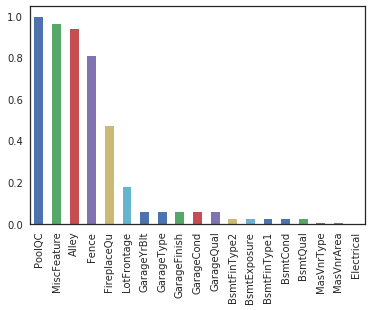

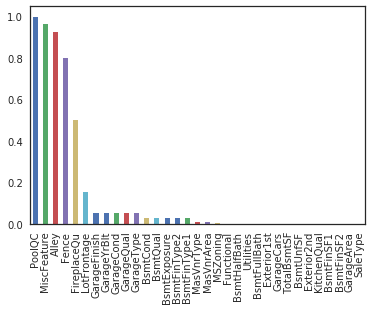

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
5             50       RL         85.0    14115   Pave   NaN      IR1   
6             20       RL         75.0    10084   Pave   NaN      Reg   
7             60       RL          NaN    10382   Pave   NaN      IR1   
8             50       RM         51.0     6120   Pave   NaN      Reg   
9            190       RL         50.0     7420   Pave   NaN      Reg   
10            20       RL         70.0    11200   Pave   NaN      Reg   
11            60       RL         85.0    11924   Pave   NaN      IR1   
12            20       RL          NaN    12968   P

In [294]:
### Dealing With Missing Values

# calculate percent of NA values in a column

def percent_missing(df, column):
    missing = float(df[column].isna().sum())
    total = len(df[column])
    return missing/total

# displays bar graph of % of column missing (compare train and holdout before using drop_over_x on both)

def display_missing(df):
    percent_NA = {}
    for col in df.columns:
        if percent_missing(df, col) == 0:
            pass
        else:
            percent_NA[col] = percent_missing(df, col)
### Next two lines should be their own function: sort_dict             
    values = pd.Series(percent_NA.values(), index=percent_NA.keys())
    sorted_values = values.sort_values(ascending=False)
    sorted_values.plot.bar()
    plt.show()
    return sorted_values

# drop columns with higher than certain % missing values

def drop_over_x(df, x_percent):
    for col in df.columns:
        if percent_missing(df, col) >= x_percent:
            print(col)
            df = df.drop(labels=col, axis=1)
    return df


display_missing(train)
display_missing(holdout)
print(train)

# before blindly using this, check that the missing values aren't useful
# train = drop_over_x(train, .60) # this means FireplaceQu is still there with over 40% missing values
# holdout = drop_over_x(holdout, .60)

### new function
### fill in missing values (does making a dummy variable make NA into 0?)

In [237]:
# works for both int and object datatypes
# if no missing values, drops last column to avoid dummy variable trap
# does making a dummy variable turn NA into 0? Otherwise what do i do with missing values?

def make_dummies(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        if percent_missing(df, column) == 0:
            df = df.drop(labels=column, axis=1)
        else:
            df = df.drop(labels=column, axis=1)
            df = df.drop(labels=df.columns[-1], axis=1)
    return df

In [238]:
# over 60% missing values
Alley
PoolQC
Fence
MiscFeature

# Before making dummy variables, run correlation
I expect YearBuilt and YearRemodAdd to be correlated because the latter uses the prior

# continuous to categorical (some here could also go to normalize/rescale instead)
['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd']?

# categorical to continuos?
OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, HeatingQC


# make dummy variables for
['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig',
 'LandSlope','Neighborhood','BldgType','HouseStyle','RoofMatl','MasVnrType',
'Foundation','Heating','Electrical',]
CentralAir - fill missing values with No

# normalize/rescale
TotalBsmtSF, 1stFlrSF, 2ndFlrSF (combine those two?)

# extra
can I combine Condition1 and Condition2?
can I combine Exterior1st and Exterior2nd?
BsmtFinType1 and BsmtFinType2
BsmtFinSF1 and BsmtFinSF2
BsmtUnfSF seems redundand


left off at LowQualFinSF

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [278]:
### As quickly as possible:

# Get columns in a list
columns = train.columns
object_columns = []
non_object_columns = []
for col in columns:
    if train[col].dtype.name == 'object':
        object_columns.append(col)
    else:
        non_object_columns.append(col)
# print(object_columns)
# print(non_object_columns)

# Identify ALL categorical columns
for i in object_columns:
    print(i)



# (rethinking dummy function - should I drop anything at all?)
# Make dummies for both data sets
# Run regression, record accuracy
# Submit, record accuracy
# Use RFECV, repeat last two steps. Use GridSearchCV, repeat last two steps
### Only THEN approach problem by reading tutorial, carefully considering features, using correlation, etc.
### For Tutorial, record new advice under some part of the four step process
### Review Titanic Competition and do the same (Note Linear vs Logistic techniques)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


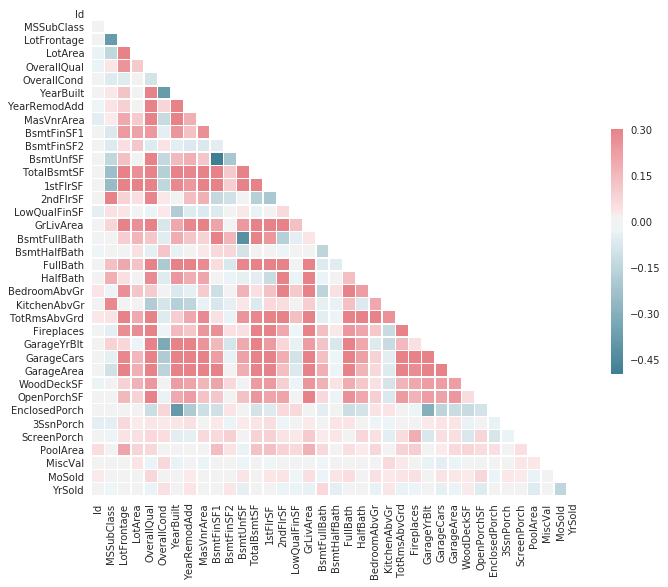

In [251]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

plot_correlation_heatmap(train)

In [75]:
# fill missing values with mean

def process_missing(df):
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mean())
    return df

In [253]:
# value counts of datatypes of columns

i = pd.Series([train[column].dtype for column in train.columns])
print(i.value_counts())

# show column names with datatype

for column in train.columns:
    print(column, train[column].dtype)
    
train.select_dtypes()

object     39
int64      34
float64     3
dtype: int64
('Id', dtype('int64'))
('MSSubClass', dtype('int64'))
('MSZoning', dtype('O'))
('LotFrontage', dtype('float64'))
('LotArea', dtype('int64'))
('Street', dtype('O'))
('LotShape', dtype('O'))
('LandContour', dtype('O'))
('Utilities', dtype('O'))
('LotConfig', dtype('O'))
('LandSlope', dtype('O'))
('Neighborhood', dtype('O'))
('Condition1', dtype('O'))
('Condition2', dtype('O'))
('BldgType', dtype('O'))
('HouseStyle', dtype('O'))
('OverallQual', dtype('int64'))
('OverallCond', dtype('int64'))
('YearBuilt', dtype('int64'))
('YearRemodAdd', dtype('int64'))
('RoofStyle', dtype('O'))
('RoofMatl', dtype('O'))
('Exterior1st', dtype('O'))
('Exterior2nd', dtype('O'))
('MasVnrType', dtype('O'))
('MasVnrArea', dtype('float64'))
('ExterQual', dtype('O'))
('ExterCond', dtype('O'))
('Foundation', dtype('O'))
('BsmtQual', dtype('O'))
('BsmtCond', dtype('O'))
('BsmtExposure', dtype('O'))
('BsmtFinType1', dtype('O'))
('BsmtFinSF1', dtype('int64'))
('B

ValueError: at least one of include or exclude must be nonempty

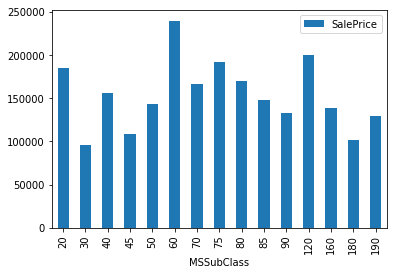

In [106]:
pivot = train.pivot_table(index='MSSubClass', values='SalePrice')
pivot.plot.bar()

In [169]:
# normalize/rescale columns

from sklearn.preprocessing import minmax_scale

def rescale(df, column):
    df[col + '_scaled'] = minmax_scale(train[column])
    # df = df.drop(labels=column, axis=1)
    return df

# for column in column_list:
#     df = rescale(df, column)

0.0554794520548


In [12]:
columns = ['MSSubClass','MSZoning']
for col in columns:
    train = make_dummies(train, col)
    holdout = make_dummies(holdout, col)

81


In [13]:
temp = make_dummies(temp, 'MSZoning')
print(len(temp.columns))

85


In [15]:
temp = make_dummies(temp, 'MSSubClass')
print(len(temp.columns))

99


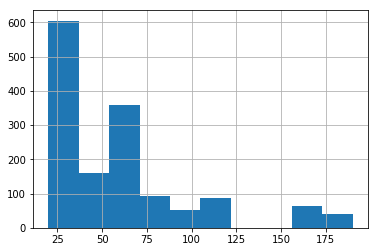

In [26]:
train['MSSubClass'].hist()

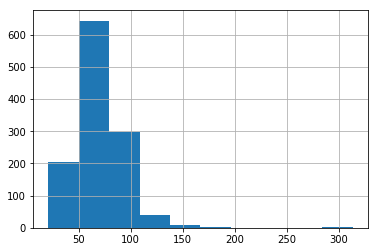

In [31]:
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.dropna(axis=1)
    for column in df.columns:
        if (df[column].dtype.name == 'object') or (df[column].dtype.name == 'category'):
            df = df.drop(labels=column, axis=1)
    all_X = df.drop(labels=['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    print(all_X.columns[selector.support_])
    return all_X.columns[selector.support_]

optimized_columns = select_features(train)